### Colr Histogram vs. raw pixels as features

In [1]:
# import the necessary packages
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import precision_recall_fscore_support as score_prfs
from sklearn.externals import joblib
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import imutils
import cv2
import os

import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])

    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)

    # otherwise, perform "in place" normalization in OpenCV 3 (I
    # personally hate the way this is done
    else:
        cv2.normalize(hist, hist)

    # return the flattened histogram as the feature vector
    return hist.flatten()

In [3]:
if os.path.isfile("Image_n_Labels/trainImages.npy") &  os.path.isfile("Image_n_Labels/trainLabels.npy") :
    print("Loading from npy files...")
    X = np.load("Image_n_Labels/trainImages.npy")
    y = np.load("Image_n_Labels/trainLabels.npy")
    print("Training images and labels are loaded in variables ==> X,y")
    print("Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))
else:    
    # training images and labels
    trainImages, trainLabels = readTrafficSigns('../../GTSRB/train/Final_Training/Images/')
    np.save("Image_n_Labels/trainImages.npy",trainImages)
    np.save("Image_n_Labels/trainLabels.npy",trainLabels)
    print("training images and labels are read from the dataset directory")
    print("training images saved to Image_n_Labels/trainingImages.npy for further use")
    print("training labels saved to Image_n_Labels/trainingLabels.npy for further use")

Loading from npy files...
Training images and labels are loaded in variables ==> X,y
Number of training Images 39209 
Number of Labels 39209


In [4]:
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
rawImages = []
features = []
labels = y
# loop over the input images
for i in range(0,len(X)):
# for i in range(0,10):
    image = X[i]
    # extract raw pixel intensity "features", followed by a color
    # histogram to characterize the color distribution of the pixels
    # in the image
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
    # update the raw images, features, and labels matricies,
    # respectively
    rawImages.append(pixels)
    features.append(hist)

    # show an update every 3,000 images
    if i > 0 and i % 3000 == 0:
        print("[INFO] processed {}/{}".format(i, len(X)))

[INFO] processed 3000/39209
[INFO] processed 6000/39209
[INFO] processed 9000/39209
[INFO] processed 12000/39209
[INFO] processed 15000/39209
[INFO] processed 18000/39209
[INFO] processed 21000/39209
[INFO] processed 24000/39209
[INFO] processed 27000/39209
[INFO] processed 30000/39209
[INFO] processed 33000/39209
[INFO] processed 36000/39209
[INFO] processed 39000/39209


In [5]:
print("[INFO] hsv color histogram features : {}x{}".format(X.shape[0],len(features[0])))

print("[INFO] raw pixel features : {}x{}".format(X.shape[0],len(rawImages[0])))
print("[INFO] shape of labels : {}".format(labels.shape))

[INFO] hsv color histogram features : 39209x512
[INFO] raw pixel features : 39209x3072
[INFO] shape of labels : (39209,)


In [6]:
# show some information on the memory consumed by the raw images
# matrix and features matrix
rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 117.63MB
[INFO] features matrix: 78.42MB


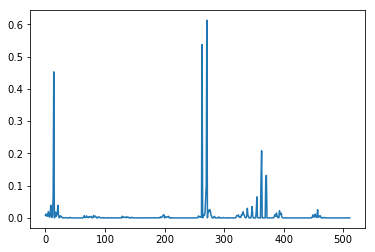

In [7]:
plt.plot(features[149])
plt.show()

In [8]:
# partition the data into training and testing splits, using 75%
# of the data for training and the remaining 25% for testing
(trainRI, testRI, trainRL, testRL) = train_test_split(rawImages, labels, test_size=0.25, random_state=42)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(features, labels, test_size=0.25, random_state=42)

### classification accuracy on raw pixels as features

In [33]:
# train and evaluate a k-NN classifer on the raw pixel intensities
print("[INFO] evaluating raw pixel accuracy...")
model = KNeighborsClassifier(n_neighbors=1,n_jobs=-1)
model.fit(trainRI, trainRL)
acc = model.score(testRI, testRL)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))


[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 92.41%


In [9]:
# train and evaluate a k-NN classifer on the histogram
# representations
# if os.path.isfile('c'
if os.path.isfile("clf/clf_knn1_clrhist.pkl"):
    print("[INFO] loading classifier: KNN =1 trained on color histogram features...")
    model= joblib.load("clf/clf_knn1_clrhist.pkl")
    print("[INFO] Classifer is loaded as instance ::model::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \KNN = 1")
    model = KNeighborsClassifier(n_neighbors=1,n_jobs=2)
    model.fit(trainFeat, trainLabels)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(model, 'clf/clf_knn1_clrhist.pkl') 
    print("[INFO] Classifier Saved")

[INFO] loading classifier: KNN =1 trained on color histogram features...
[INFO] Classifer is loaded as instance ::model::


### Classification accuracy on color histogram as features

In [10]:
print("[INFO] evaluating histogram accuracy...")
acc = model.score(testFeat, testLabels)
print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))


[INFO] evaluating histogram accuracy...
[INFO] histogram accuracy: 97.10%


In [11]:
predicted = model.predict(testFeat)


In [12]:
p,r,f,s = score_prfs(predicted, testLabels, average='weighted')

In [13]:
print("[INFO] \n precision: {:.2f}%\n recall: {:.2f}%\n f1_score:{:.2f}%".format(p*100,r*100,f*100))

[INFO] 
 precision: 97.12%
 recall: 97.10%
 f1_score:97.10%


In [14]:
def testing_on_data():
    n = np.random.randint(39000)
    test1 =X[n]
    plt.imshow(test1)
    plt.show()
    t1_true = y[n]
    t1_feat =  extract_color_histogram(test1)
    t1_predict = model.predict(t1_feat)
    print("==========")
    print("True :{}\npredicted:{}\n".format(t1_true,t1_predict[0]))
    print("==========")
    font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf", 10)
    img = Image.fromarray(test1)
    draw = ImageDraw.Draw(img)
    draw.text((0,0), str(t1_predict), (0,255,0), font=font)
    draw = ImageDraw.Draw(img)
    plt.show(img)     

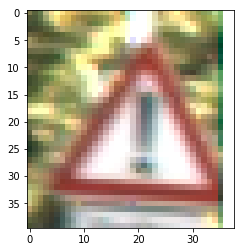

True :18
predicted:18



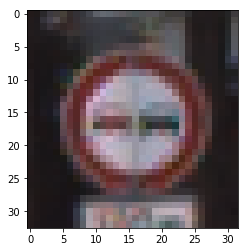

True :9
predicted:9



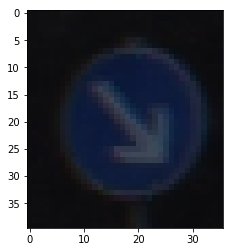

True :38
predicted:38



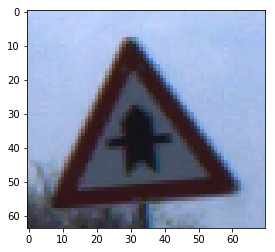

True :11
predicted:11



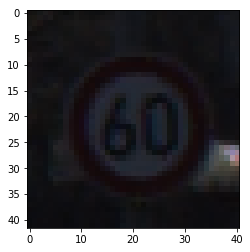

True :3
predicted:3



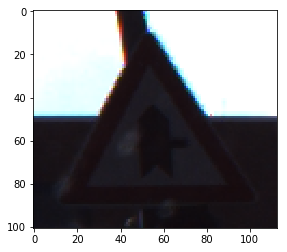

True :11
predicted:11



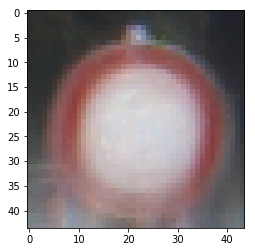

True :15
predicted:15



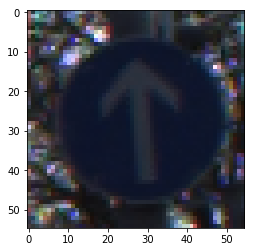

True :35
predicted:35



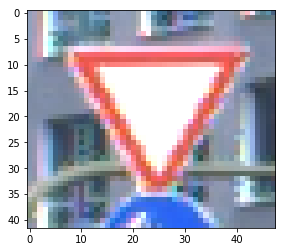

True :13
predicted:13



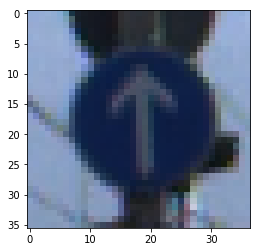

True :35
predicted:35



In [15]:
for i in range(10):
    testing_on_data()